In [1]:
# Try some predictions with an SVM:

# https://www.geeksforgeeks.org/predicting-stock-price-direction-using-support-vector-machines/

from sklearn.svm import SVC 
from sklearn.metrics import accuracy_score 

# TDODO look at differences in SVM and SVC

import pandas as pd 
import numpy as np 
  
# To plot 
import matplotlib.pyplot as plt 

import warnings 
warnings.filterwarnings("ignore")


In [2]:
df = pd.read_csv('all_stocks_5yr.csv')
df.head()

,date,open,high,low,close,volume,Name
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL
3,2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL
4,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL


In [3]:
# Get all unique stock names:

unique_values = df['Name'].unique()
print(unique_values)

['AAL' 'AAPL' 'AAP' 'ABBV' 'ABC' 'ABT' 'ACN' 'ADBE' 'ADI' 'ADM' 'ADP'
 'ADSK' 'ADS' 'AEE' 'AEP' 'AES' 'AET' 'AFL' 'AGN' 'AIG' 'AIV' 'AIZ' 'AJG'
 'AKAM' 'ALB' 'ALGN' 'ALK' 'ALLE' 'ALL' 'ALXN' 'AMAT' 'AMD' 'AME' 'AMGN'
 'AMG' 'AMP' 'AMT' 'AMZN' 'ANDV' 'ANSS' 'ANTM' 'AON' 'AOS' 'APA' 'APC'
 'APD' 'APH' 'APTV' 'ARE' 'ARNC' 'ATVI' 'AVB' 'AVGO' 'AVY' 'AWK' 'AXP'
 'AYI' 'AZO' 'A' 'BAC' 'BAX' 'BA' 'BBT' 'BBY' 'BDX' 'BEN' 'BF.B' 'BHF'
 'BHGE' 'BIIB' 'BK' 'BLK' 'BLL' 'BMY' 'BRK.B' 'BSX' 'BWA' 'BXP' 'CAG'
 'CAH' 'CAT' 'CA' 'CBG' 'CBOE' 'CBS' 'CB' 'CCI' 'CCL' 'CDNS' 'CELG' 'CERN'
 'CFG' 'CF' 'CHD' 'CHK' 'CHRW' 'CHTR' 'CINF' 'CI' 'CLX' 'CL' 'CMA' 'CMCSA'
 'CME' 'CMG' 'CMI' 'CMS' 'CNC' 'CNP' 'COF' 'COG' 'COL' 'COO' 'COP' 'COST'
 'COTY' 'CPB' 'CRM' 'CSCO' 'CSRA' 'CSX' 'CTAS' 'CTL' 'CTSH' 'CTXS' 'CVS'
 'CVX' 'CXO' 'C' 'DAL' 'DE' 'DFS' 'DGX' 'DG' 'DHI' 'DHR' 'DISCA' 'DISCK'
 'DISH' 'DIS' 'DLR' 'DLTR' 'DOV' 'DPS' 'DRE' 'DRI' 'DTE' 'DUK' 'DVA' 'DVN'
 'DWDP' 'DXC' 'D' 'EA' 'EBAY' 'ECL' 'ED' 'EFX' 'EIX' 'E

In [4]:
# Filter down to just one stock
df = df.rename(columns={'Name': 'Ticks'})

amzn = df.loc[df['Ticks'] == 'AMZN']
amzn.head()

,date,open,high,low,close,volume,Ticks
46387,2013-02-08,261.40,265.25,260.555,261.95,3879078,AMZN
46388,2013-02-11,263.20,263.25,256.600,257.21,3403403,AMZN
46389,2013-02-12,259.19,260.16,257.000,258.70,2938660,AMZN
46390,2013-02-13,261.53,269.96,260.300,269.47,5292996,AMZN
46391,2013-02-14,267.37,270.65,265.400,269.24,3462780,AMZN


In [5]:
amzn.index = pd.to_datetime(amzn['date']) 

amzn = amzn.drop(['date'], axis='columns') 

In [6]:
# Create predictor variables 
amzn['Open-Close'] = amzn['open'] - amzn['close']
amzn['High-Low'] = amzn['high'] - amzn['low']
  
# Store all predictor variables in a variable X 
X = amzn[['Open-Close', 'High-Low']] 
X.head() 

,Open-Close,High-Low
date,,
2013-02-08,-0.55,4.695
2013-02-11,5.99,6.650
2013-02-12,0.49,3.160
2013-02-13,-7.94,9.660
2013-02-14,-1.87,5.250


In [7]:
amzn.head()

,open,high,low,close,volume,Ticks,Open-Close,High-Low
date,,,,,,,,
2013-02-08,261.40,265.25,260.555,261.95,3879078,AMZN,-0.55,4.695
2013-02-11,263.20,263.25,256.600,257.21,3403403,AMZN,5.99,6.650
2013-02-12,259.19,260.16,257.000,258.70,2938660,AMZN,0.49,3.160
2013-02-13,261.53,269.96,260.300,269.47,5292996,AMZN,-7.94,9.660
2013-02-14,267.37,270.65,265.400,269.24,3462780,AMZN,-1.87,5.250


In [8]:

# If the next day close is greater than the current day close, classify as buy (1)
# else it is a no-position (0)
y = np.where(amzn['close'].shift(-1) > amzn['close'], 1, 0) 
print(y)

# TODO here we either predict and buy one unit of the stock, or we predict that we should not hold a unit 
# this does not factor in the potential cost of buying or selling, it assumes a hold and not-hold is free for a single unit

[0 1 1 ... 1 0 0]


In [9]:
# Split and train on a buy and a sell
split_percentage = 0.8
split = int(split_percentage*len(amzn)) 
  
# Train data set 
X_train = X[:split] 
y_train = y[:split] 
  
# Test data set 
X_test = X[split:] 
y_test = y[split:]

In [10]:

# TODO: we can try with different kernel functions: https://www.geeksforgeeks.org/major-kernel-functions-in-support-vector-machine-svm/

svm = SVC(kernel ='poly')
cls = svm.fit(X_train, y_train)

y_pred = cls.predict(X_test)
y_pred_train = cls.predict(X_train)

accuracy = accuracy_score(y_test, y_pred)
print("Test accuracy:", accuracy)

accuracy = accuracy_score(y_train, y_pred_train)
print("Train accuracy:", accuracy)

Test accuracy: 0.5714285714285714
Train accuracy: 0.5342601787487586


In [11]:
svm = SVC(kernel ='linear')
cls = svm.fit(X_train, y_train)

y_pred = cls.predict(X_test)
y_pred_train = cls.predict(X_train)

accuracy = accuracy_score(y_test, y_pred)
print("Test accuracy:", accuracy)

accuracy = accuracy_score(y_train, y_pred_train)
print("Train accuracy:", accuracy)

Test accuracy: 0.5714285714285714
Train accuracy: 0.5332671300893744


In [12]:
# TODO In this case, sigmoid seems to have the highest test accuracy
# However, if you try to use to predict returns it performs worse for some reason

svm = SVC(kernel ='sigmoid')
cls = svm.fit(X_train, y_train)

y_pred = cls.predict(X_test)
y_pred_train = cls.predict(X_train)

accuracy = accuracy_score(y_test, y_pred)
print("Test accuracy:", accuracy)

accuracy = accuracy_score(y_train, y_pred_train)
print("Train accuracy:", accuracy)

Test accuracy: 0.5753968253968254
Train accuracy: 0.5153922542204568


In [13]:
svm = SVC(kernel ='rbf')
cls = svm.fit(X_train, y_train)

y_pred = cls.predict(X_test)
y_pred_train = cls.predict(X_train)

accuracy = accuracy_score(y_test, y_pred)
print("Test accuracy:", accuracy)

accuracy = accuracy_score(y_train, y_pred_train)
print("Train accuracy:", accuracy)

Test accuracy: 0.5714285714285714
Train accuracy: 0.535253227408143


In [14]:
amzn['Predicted_Signal'] = cls.predict(X)

In [15]:
amzn['Return'] = amzn['close'].pct_change()

In [16]:
amzn['Strategy_Return'] = amzn.Return *amzn.Predicted_Signal.shift(1)


In [17]:
amzn['Cum_Ret'] = amzn['Return'].cumsum() 

In [18]:
amzn['Cum_Strategy'] = amzn['Strategy_Return'].cumsum() 


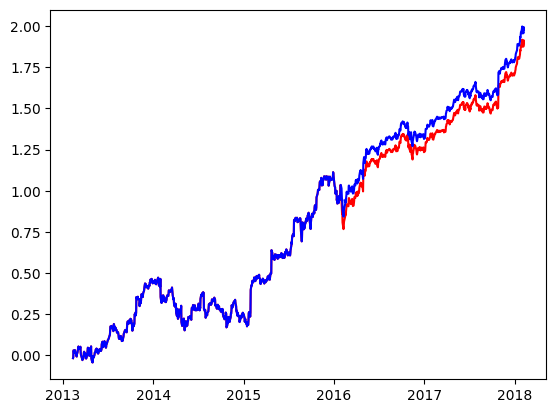

In [19]:
plt.plot(amzn['Cum_Ret'],color='red') 
plt.plot(amzn['Cum_Strategy'],color='blue')

Modeling  AMZN
Test accuracy: 0.5714285714285714
Train accuracy: 0.535253227408143
              open    high      low   close   volume Ticks  Open-Close  \
date                                                                     
2013-02-08  261.40  265.25  260.555  261.95  3879078  AMZN       -0.55   
2013-02-11  263.20  263.25  256.600  257.21  3403403  AMZN        5.99   
2013-02-12  259.19  260.16  257.000  258.70  2938660  AMZN        0.49   
2013-02-13  261.53  269.96  260.300  269.47  5292996  AMZN       -7.94   
2013-02-14  267.37  270.65  265.400  269.24  3462780  AMZN       -1.87   

            High-Low  Predicted_Signal    Return  Strategy_Return   Cum_Ret  \
date                                                                          
2013-02-08     4.695                 1       NaN              NaN       NaN   
2013-02-11     6.650                 1 -0.018095        -0.018095 -0.018095   
2013-02-12     3.160                 1  0.005793         0.005793 -0.012302   
201

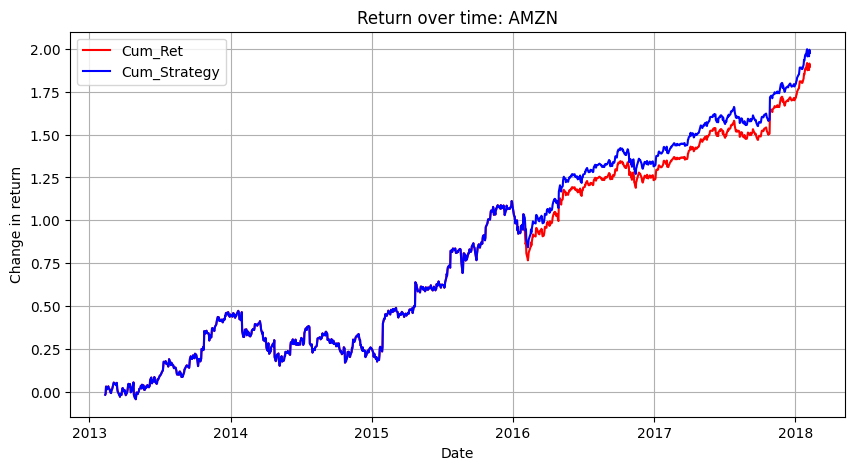

Modeling  AAPL
Test accuracy: 0.5
Train accuracy: 0.5362462760675273
               open     high      low    close     volume Ticks  Open-Close  \
date                                                                          
2013-02-08  67.7142  68.4014  66.8928  67.8542  158168416  AAPL     -0.1400   
2013-02-11  68.0714  69.2771  67.6071  68.5614  129029425  AAPL     -0.4900   
2013-02-12  68.5014  68.9114  66.8205  66.8428  151829363  AAPL      1.6586   
2013-02-13  66.7442  67.6628  66.1742  66.7156  118721995  AAPL      0.0286   
2013-02-14  66.3599  67.3771  66.2885  66.6556   88809154  AAPL     -0.2957   

            High-Low  Predicted_Signal    Return  Strategy_Return   Cum_Ret  \
date                                                                          
2013-02-08    1.5086                 1       NaN              NaN       NaN   
2013-02-11    1.6700                 1  0.010422         0.010422  0.010422   
2013-02-12    2.0909                 1 -0.025067        -0.02

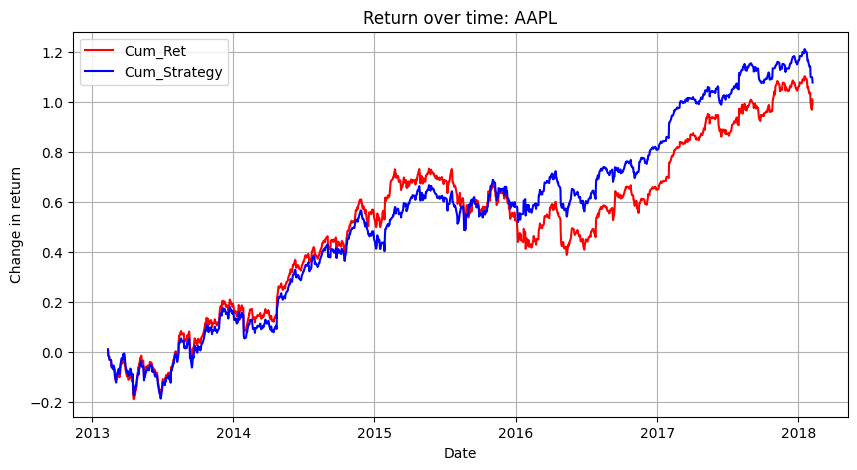

Modeling  MSFT
Test accuracy: 0.5555555555555556
Train accuracy: 0.5441906653426017
             open   high    low  close    volume Ticks  Open-Close  High-Low  \
date                                                                           
2013-02-08  27.35  27.71  27.31  27.55  33318306  MSFT       -0.20      0.40   
2013-02-11  27.65  27.92  27.50  27.86  32247549  MSFT       -0.21      0.42   
2013-02-12  27.88  28.00  27.75  27.88  35990829  MSFT        0.00      0.25   
2013-02-13  27.93  28.11  27.88  28.03  41715530  MSFT       -0.10      0.23   
2013-02-14  27.92  28.06  27.87  28.04  32663174  MSFT       -0.12      0.19   

            Predicted_Signal    Return  Strategy_Return   Cum_Ret  \
date                                                                
2013-02-08                 1       NaN              NaN       NaN   
2013-02-11                 1  0.011252         0.011252  0.011252   
2013-02-12                 1  0.000718         0.000718  0.011970   
2013-02-13

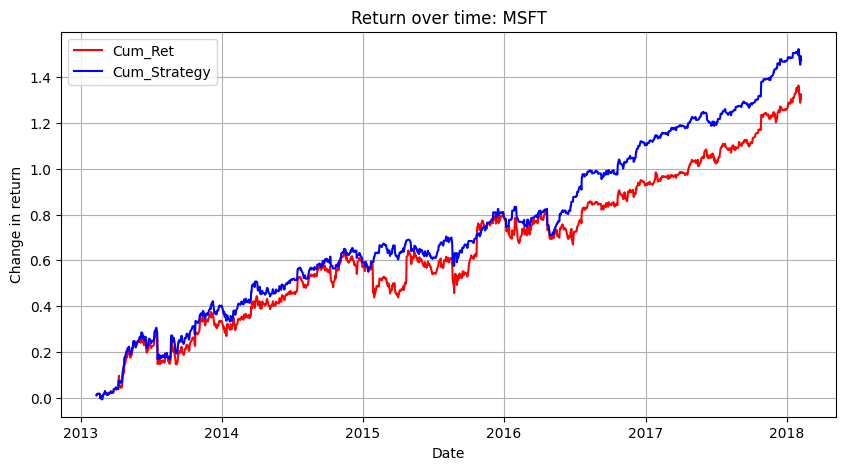

Modeling  WMT
Test accuracy: 0.4880952380952381
Train accuracy: 0.5431976166832175
             open   high     low  close   volume Ticks  Open-Close  High-Low  \
date                                                                           
2013-02-08  71.20  71.64  71.070  71.48  5906823   WMT       -0.28     0.570   
2013-02-11  71.25  71.51  70.530  71.40  6202534   WMT       -0.15     0.980   
2013-02-12  71.49  71.66  71.100  71.40  4761910   WMT        0.09     0.560   
2013-02-13  71.29  71.70  71.210  71.39  3969807   WMT       -0.10     0.490   
2013-02-14  71.10  71.23  70.755  70.82  6820952   WMT        0.28     0.475   

            Predicted_Signal    Return  Strategy_Return   Cum_Ret  \
date                                                                
2013-02-08                 0       NaN              NaN       NaN   
2013-02-11                 1 -0.001119             -0.0 -0.001119   
2013-02-12                 0  0.000000              0.0 -0.001119   
2013-02-13 

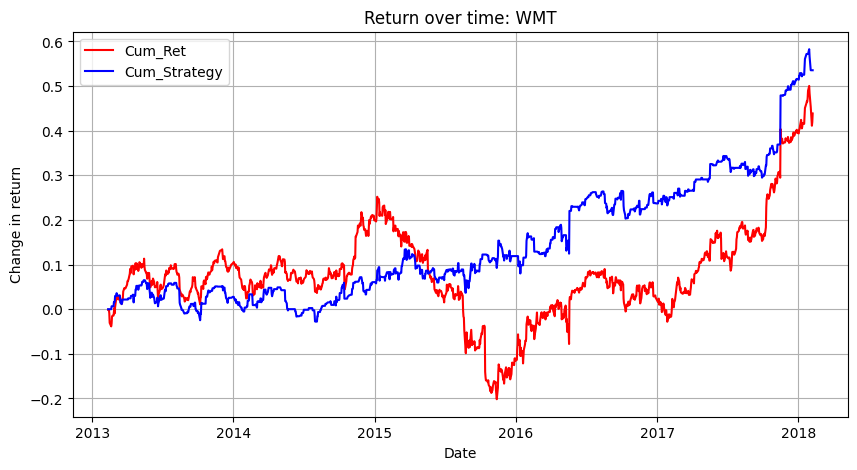

Modeling  V
Test accuracy: 0.5873015873015873
Train accuracy: 0.548162859980139
               open     high     low    close    volume Ticks  Open-Close  \
date                                                                        
2013-02-08  39.3500  39.7350  39.275  39.4500  12913800     V     -0.1000   
2013-02-11  39.3950  39.5425  38.985  39.0825  11032112     V      0.3125   
2013-02-12  39.2100  39.4250  39.105  39.2000   9805312     V      0.0100   
2013-02-13  39.1125  39.3475  38.535  38.6925  13915520     V      0.4200   
2013-02-14  38.6500  39.1625  38.575  38.9950  12760368     V     -0.3450   

            High-Low  Predicted_Signal    Return  Strategy_Return   Cum_Ret  \
date                                                                          
2013-02-08    0.4600                 1       NaN              NaN       NaN   
2013-02-11    0.5575                 1 -0.009316        -0.009316 -0.009316   
2013-02-12    0.3200                 1  0.003006         0.00300

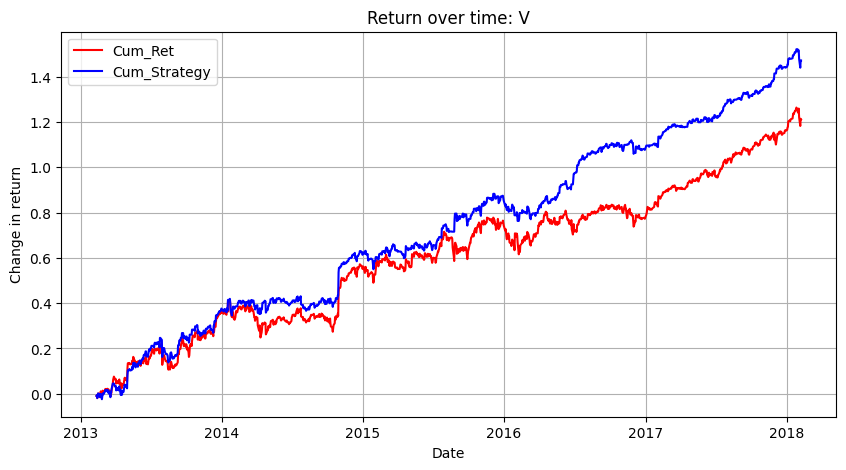

Modeling  MA
Test accuracy: 0.5912698412698413
Train accuracy: 0.5600794438927508
              open    high      low   close   volume Ticks  Open-Close  \
date                                                                     
2013-02-08  51.846  52.447  51.8310  52.447  5214240    MA      -0.601   
2013-02-11  52.562  52.616  51.9235  52.085  5615190    MA       0.477   
2013-02-12  52.086  52.213  51.8510  51.964  3378040    MA       0.122   
2013-02-13  52.125  52.190  51.6180  51.921  4095090    MA       0.204   
2013-02-14  51.615  52.326  51.6150  52.216  6655150    MA      -0.601   

            High-Low  Predicted_Signal    Return  Strategy_Return   Cum_Ret  \
date                                                                          
2013-02-08    0.6160                 1       NaN              NaN       NaN   
2013-02-11    0.6925                 1 -0.006902        -0.006902 -0.006902   
2013-02-12    0.3620                 1 -0.002323        -0.002323 -0.009225   
2013

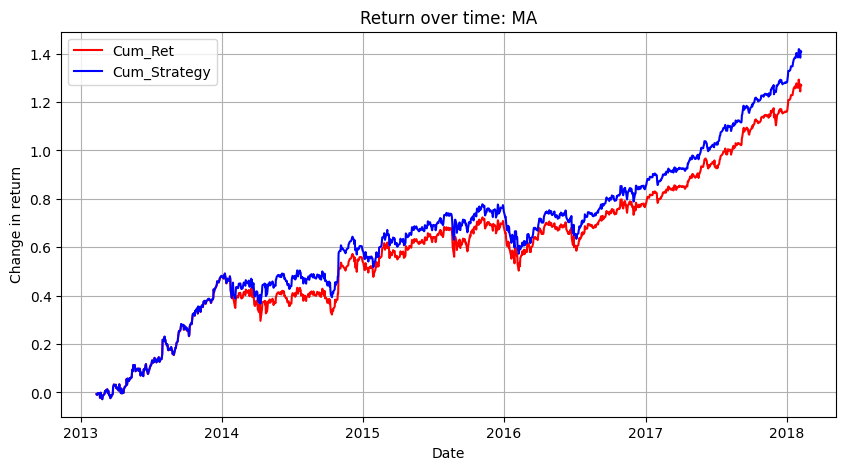

Modeling  COST
Test accuracy: 0.4722222222222222
Train accuracy: 0.5302879841112215
              open    high      low   close   volume Ticks  Open-Close  \
date                                                                     
2013-02-08  102.38  102.96  101.810  102.79  1726289  COST       -0.41   
2013-02-11  102.87  102.94  101.760  101.99  1457384  COST        0.88   
2013-02-12  102.21  102.23  101.530  101.76  1203174  COST        0.45   
2013-02-13  101.98  102.37  100.950  101.63  1224373  COST        0.35   
2013-02-14  101.04  102.06  101.012  102.02  2211142  COST       -0.98   

            High-Low  Predicted_Signal    Return  Strategy_Return   Cum_Ret  \
date                                                                          
2013-02-08     1.150                 0       NaN              NaN       NaN   
2013-02-11     1.180                 0 -0.007783             -0.0 -0.007783   
2013-02-12     0.700                 0 -0.002255             -0.0 -0.010038   
20

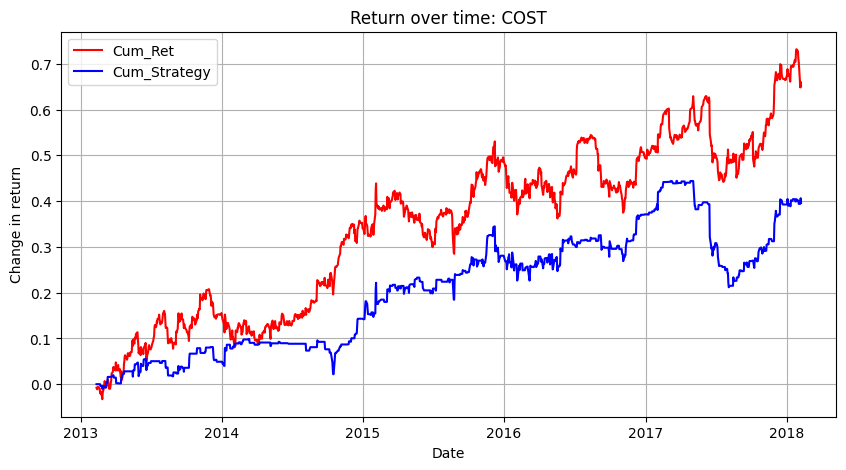

Modeling  PEP
Test accuracy: 0.5357142857142857
Train accuracy: 0.5422045680238332
             open   high    low  close    volume Ticks  Open-Close  High-Low  \
date                                                                           
2013-02-08  72.76  72.87  72.47  72.60   3721381   PEP        0.16      0.40   
2013-02-11  72.50  72.64  72.20  72.36   3743992   PEP        0.14      0.44   
2013-02-12  72.42  72.45  72.06  72.17   6397975   PEP        0.25      0.39   
2013-02-13  72.24  72.37  70.98  71.50  12030221   PEP        0.74      1.39   
2013-02-14  72.12  73.20  71.50  72.28   8160764   PEP       -0.16      1.70   

            Predicted_Signal    Return  Strategy_Return   Cum_Ret  \
date                                                                
2013-02-08                 1       NaN              NaN       NaN   
2013-02-11                 1 -0.003306        -0.003306 -0.003306   
2013-02-12                 1 -0.002626        -0.002626 -0.005932   
2013-02-13 

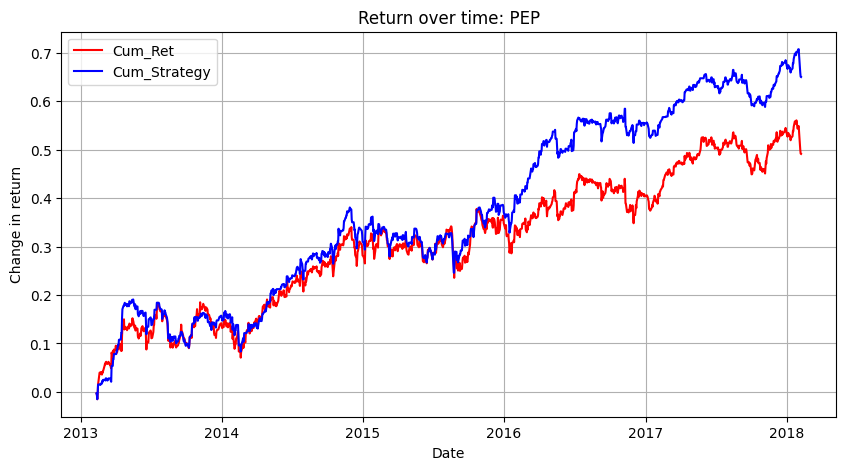

Modeling  CAT
Test accuracy: 0.4444444444444444
Train accuracy: 0.5322740814299901
             open   high    low  close   volume Ticks  Open-Close  High-Low  \
date                                                                          
2013-02-08  96.10  97.50  96.10  96.85  3934113   CAT       -0.75      1.40   
2013-02-11  96.96  96.99  96.30  96.60  2739107   CAT        0.36      0.69   
2013-02-12  96.67  97.41  96.67  97.22  4148908   CAT       -0.55      0.74   
2013-02-13  97.09  97.50  96.02  96.38  3718446   CAT        0.71      1.48   
2013-02-14  96.06  96.68  95.68  96.07  3586223   CAT       -0.01      1.00   

            Predicted_Signal    Return  Strategy_Return   Cum_Ret  \
date                                                                
2013-02-08                 0       NaN              NaN       NaN   
2013-02-11                 0 -0.002581             -0.0 -0.002581   
2013-02-12                 0  0.006418              0.0  0.003837   
2013-02-13        

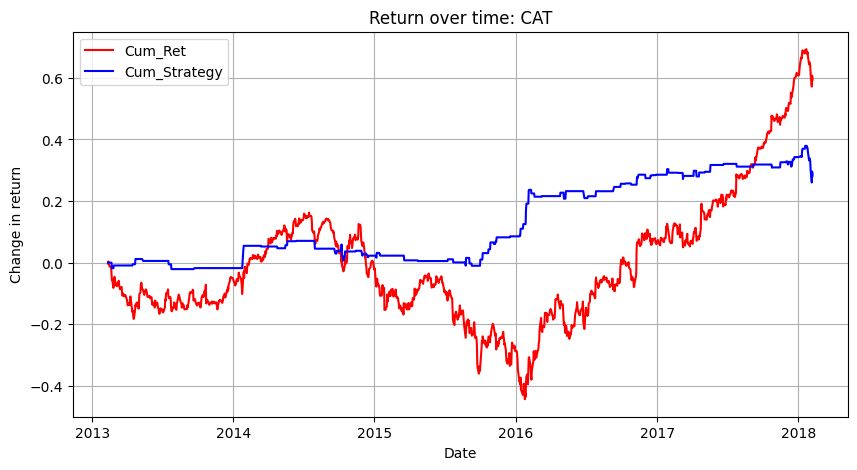

Modeling  WM
Test accuracy: 0.5634920634920635
Train accuracy: 0.548162859980139
             open     high      low  close   volume Ticks  Open-Close  \
date                                                                    
2013-02-08  36.21  36.3355  35.8100  36.30  3671444    WM       -0.09   
2013-02-11  36.31  36.4900  36.2900  36.31  1670479    WM        0.00   
2013-02-12  36.30  36.4900  36.2000  36.46  1525593    WM       -0.16   
2013-02-13  36.52  36.8200  36.4428  36.64  3343952    WM       -0.12   
2013-02-14  35.99  37.4400  35.5000  37.14  6155108    WM       -1.15   

            High-Low  Predicted_Signal    Return  Strategy_Return   Cum_Ret  \
date                                                                          
2013-02-08    0.5255                 1       NaN              NaN       NaN   
2013-02-11    0.2000                 0  0.000275         0.000275  0.000275   
2013-02-12    0.2900                 0  0.004131         0.000000  0.004407   
2013-02-13  

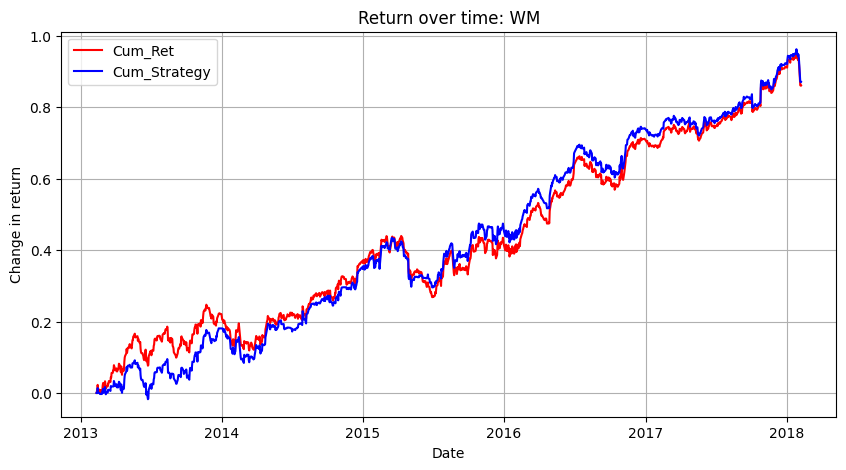

Modeling  ITW
Test accuracy: 0.5833333333333334
Train accuracy: 0.551142005958292
             open   high      low  close   volume Ticks  Open-Close  High-Low  \
date                                                                            
2013-02-08  61.90  62.73  61.7900  62.72  1560108   ITW       -0.82    0.9400   
2013-02-11  62.70  62.93  62.4800  62.80  1185514   ITW       -0.10    0.4500   
2013-02-12  62.87  63.12  62.6600  63.02  1053150   ITW       -0.15    0.4600   
2013-02-13  63.21  63.56  62.9140  63.55  1363042   ITW       -0.34    0.6460   
2013-02-14  63.55  63.87  63.4001  63.70  1488484   ITW       -0.15    0.4699   

            Predicted_Signal    Return  Strategy_Return   Cum_Ret  \
date                                                                
2013-02-08                 1       NaN              NaN       NaN   
2013-02-11                 1  0.001276         0.001276  0.001276   
2013-02-12                 1  0.003503         0.003503  0.004779   
2013-

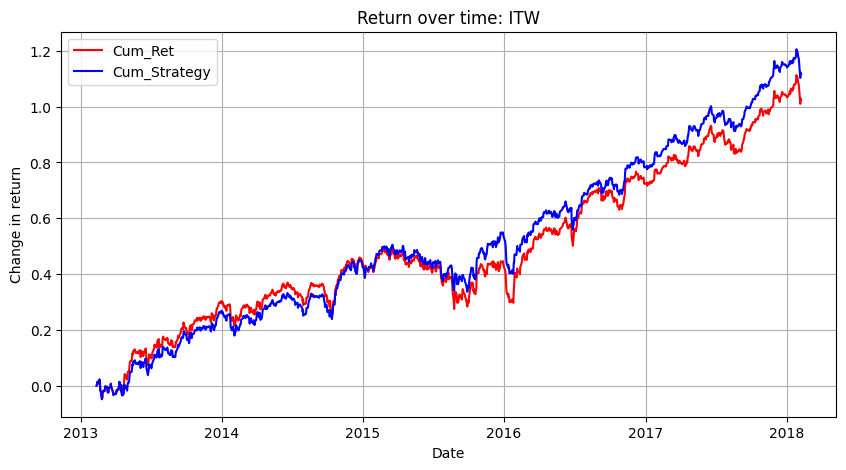

In [20]:
# Try this by looping through multiple stock symbols

# Either pick a few stocks to try
tick_names = ['AMZN', 'AAPL', 'MSFT', 'WMT', 'V', 'MA', 'COST', 'PEP', 'CAT', 'WM', 'ITW']

# OR do it for all stocks
#tick_names = unique_values

# Train a model for each stock
for name in tick_names:
    print("Modeling ", name)
    stock = df.loc[df['Ticks'] == name]
    stock.index = pd.to_datetime(stock['date']) 

    stock = stock.drop(['date'], axis='columns') 
    stock['Open-Close'] = stock['open'] - stock['close']
    stock['High-Low'] = stock['high'] - stock['low']
      
    # Store all predictor variables in a variable X 
    X = stock[['Open-Close', 'High-Low']] 
    y = np.where(stock['close'].shift(-1) > stock['close'], 1, 0) 
    split_percentage = 0.8
    split = int(split_percentage*len(stock)) 
      
    # Train data set 
    X_train = X[:split] 
    y_train = y[:split] 
      
    # Test data set 
    X_test = X[split:] 
    y_test = y[split:]

    svm = SVC()
    cls = svm.fit(X_train, y_train)
    
    y_pred = cls.predict(X_test)
    y_pred_train = cls.predict(X_train)

    accuracy = accuracy_score(y_test, y_pred)
    print("Test accuracy:", accuracy)
    
    accuracy = accuracy_score(y_train, y_pred_train)
    print("Train accuracy:", accuracy)

    stock['Predicted_Signal'] = cls.predict(X)
    stock['Return'] = stock['close'].pct_change()
    stock['Strategy_Return'] = stock.Return *stock.Predicted_Signal.shift(1)
    stock['Cum_Ret'] = stock['Return'].cumsum() 
    stock['Cum_Strategy'] = stock['Strategy_Return'].cumsum() 

    print(stock.head())

    plt.figure(figsize=(10, 5))
    plt.plot(stock['Cum_Ret'],color='red', label="Cum_Ret") 
    plt.plot(stock['Cum_Strategy'],color='blue', label="Cum_Strategy")
    plt.title('Return over time: ' + name, )
    plt.xlabel('Date')
    plt.ylabel('Change in return')
    plt.legend()
    plt.grid(True)
    plt.show()



[*********************100%%**********************]  2 of 2 completed


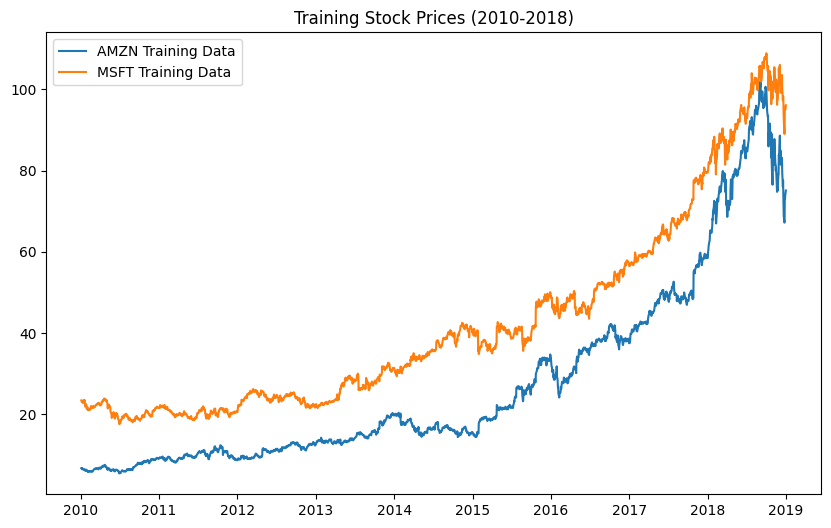

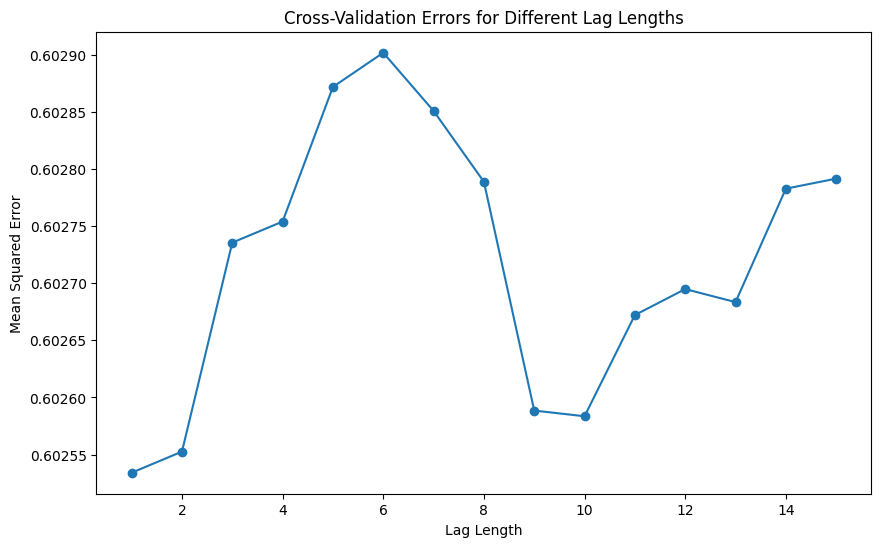

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 09, Aug, 2024
Time:                     10:23:38
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -1.93948
Nobs:                     2344.00    HQIC:                  -1.94886
Log likelihood:          -4355.63    FPE:                   0.141674
AIC:                     -1.95423    Det(Omega_mle):        0.141312
--------------------------------------------------------------------
Results for equation AMZN
             coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------
const           0.029934         0.014646            2.044           0.041
L1.AMZN         0.023472         0.027911            0.841           0.400
L1.MSFT        -0.047199         0.027530           -1.714           0.086

Results f

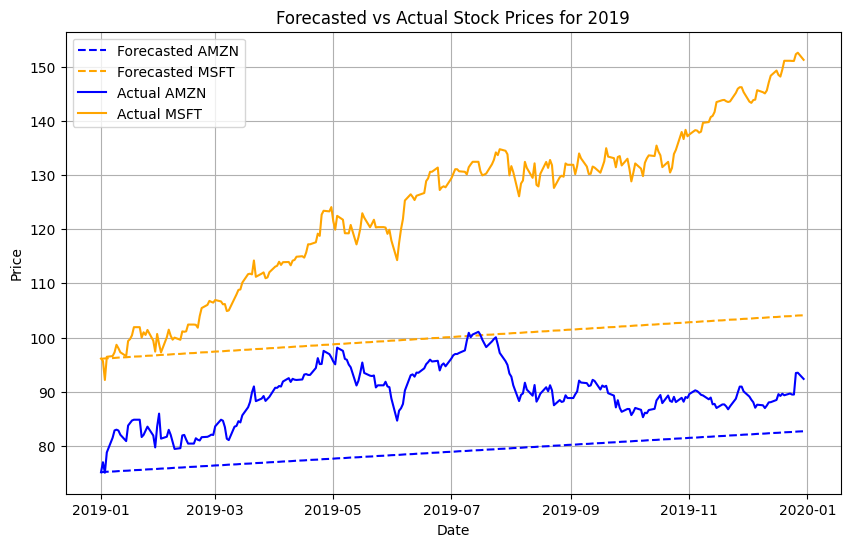

In [1]:
#VAR
import pandas as pd
import yfinance as yf
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
import numpy as np
from sklearn.metrics import mean_squared_error
train_start = '2010-01-01' # Training start date
train_end = '2018-12-31' # Training and date
forecast_start = '2019-01-01' # Forecast start date
forecast_end = '2019-12-31' # Forecast end date
stock_symbols = ['AMZN', 'MSFT'] # Define stock symbols of interest
data = yf.download(stock_symbols, start=train_start, end=forecast_end, interval='1d')['Adj Close'] # Use yahoo finance to pull stock data
data.index = pd.to_datetime(data.index) # Set data index
data = data.asfreq('B')  # Define data frequency as daily
data = data.ffill() # fill missing data 
train_data = data[train_start:train_end] # Create training data frame
forecast_dates = pd.date_range(start=forecast_start, end=forecast_end, freq='B') # Create test frame
forecast_actual_data = data[forecast_start:forecast_end] #Create test frame acual
train_data = train_data.dropna() # drop NA's
forecast_actual_data = forecast_actual_data.dropna() # drops NA's
train_data_diff = train_data.diff().dropna() # Make data stationary
# Plot the training data
plt.figure(figsize=(10, 6))
plt.plot(train_data.index, train_data['AMZN'], label='AMZN Training Data')
plt.plot(train_data.index, train_data['MSFT'], label='MSFT Training Data')
plt.title("Training Stock Prices (2010-2018)")
plt.legend()
plt.show()
tscv = TimeSeriesSplit(n_splits=5) # Set up 5-fold cross validaition
def cross_validate_VAR(data, maxlags): # set up VAR CV function 
    errors = [] # intialize error array
    for train_index, test_index in tscv.split(data): # create folds
        train, test = data.iloc[train_index], data.iloc[test_index] # establish training and test data
        model = VAR(train) # create training model
        results = model.fit(maxlags=maxlags) #gather result for given lag amount
        forecast = results.forecast(train.values[-results.k_ar:], steps=len(test)) #create forecast with current model
        error = np.mean((forecast - test.values) ** 2) #calculate MSE
        errors.append(error) # append error array
    return np.mean(errors) # return mean of errors
lag_lengths = range(1, 16) # create range of possible lags
errors = [cross_validate_VAR(train_data_diff, lag) for lag in lag_lengths] # append errors for each lag length
optimal_lag = lag_lengths[np.argmin(errors)] # find min mse and optimal lag
# Plot the cross-validation errors
plt.figure(figsize=(10, 6))
plt.plot(lag_lengths, errors, marker='o')
plt.title('Cross-Validation Errors for Different Lag Lengths')
plt.xlabel('Lag Length')
plt.ylabel('Mean Squared Error')
plt.show()
model = VAR(train_data_diff) #create optimal VAR model
results = model.fit(optimal_lag)  # Pull results of VAR model
print(results.summary()) # Print results
forecast_diff = results.forecast(train_data_diff.values[-results.k_ar:], steps=len(forecast_dates)) # Forecast 2019 using optimal model 
last_values = train_data.values[-1] #convert forecasted values
forecast = last_values + np.cumsum(forecast_diff, axis=0) # update forecast values
forecast_df = pd.DataFrame(forecast, index=forecast_dates, columns=train_data.columns) #Create forecast data frame
# Plot the forecasted data
plt.figure(figsize=(10, 6))
plt.plot(forecast_df.index, forecast_df['AMZN'], label='Forecasted AMZN', linestyle='--', color='blue')
plt.plot(forecast_df.index, forecast_df['MSFT'], label='Forecasted MSFT', linestyle='--', color='orange')
# Plot the actual data for 2019
plt.plot(forecast_actual_data.index, forecast_actual_data['AMZN'], label='Actual AMZN', color='blue')
plt.plot(forecast_actual_data.index, forecast_actual_data['MSFT'], label='Actual MSFT', color='orange')
# Add a title and labels
plt.title("Forecasted vs Actual Stock Prices for 2019")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()

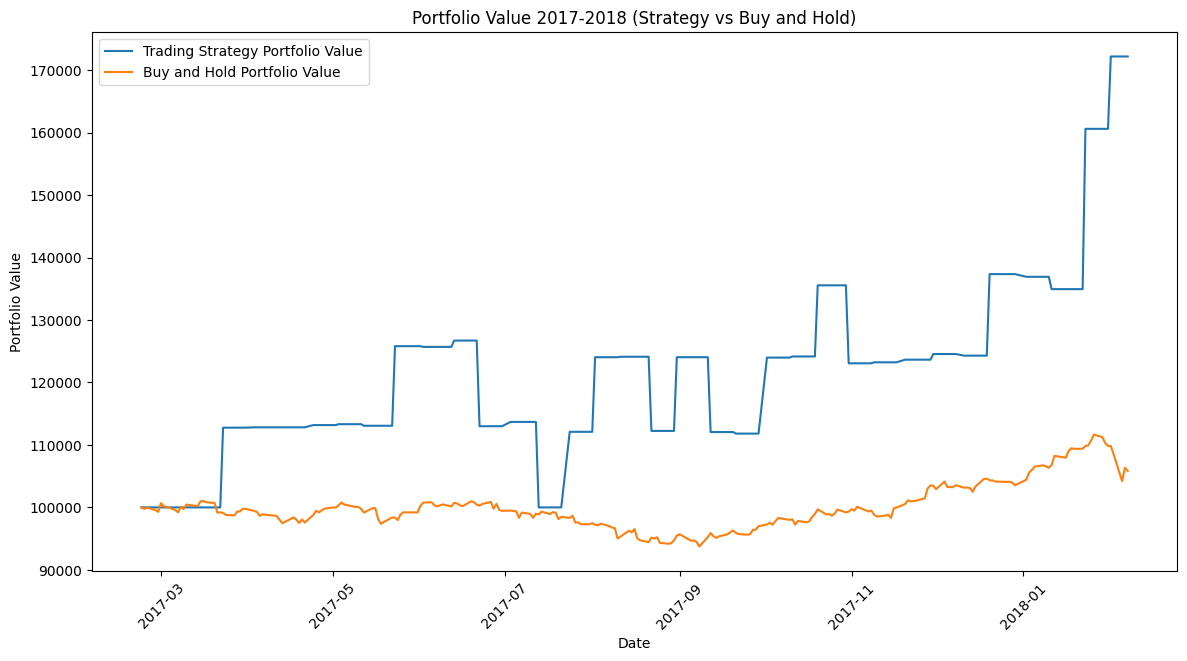

Final Trading Strategy Portfolio Value: 172175.30000000002
Final Buy and Hold Portfolio Value: 105836.92876707061


In [5]:
#SVR
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
import warnings
import picklesho

warnings.filterwarnings("ignore")

#load the dataset and preprocess
df = pd.read_csv('all_stocks_5yr.csv')
df['date'] = pd.to_datetime(df['date']) #change date column to date time format
selected_stocks = ['FITB', 'GOOGL', 'IBM', 'MSI', 'CSCO', 'PPG', 'ULTA', 'KMB'] #select a few stocks from the dataset
df = df[df['Name'].isin(selected_stocks)]
df = df.sort_values(by=['Name', 'date']) #sort stocks by name and date
#features
df['prev_close'] = df.groupby('Name')['close'].shift(1) #calc previous close
df['7d_mov_avg'] = df.groupby('Name')['close'].transform(lambda x: x.rolling(window=7).mean()) #calc 7d mov avg
df['14d_mov_avg'] = df.groupby('Name')['close'].transform(lambda x: x.rolling(window=14).mean()) #calc 14d mov avg
df['volatility'] = df.groupby('Name')['close'].transform(lambda x: x.rolling(window=7).std()) #calc 7d volatility (std dev of closing prices)
df['alpha'] = df.groupby('Name')['close'].transform(lambda x: x.pct_change(periods=7)) #calc alpha value (7d perc change in closing prices)
df = df.dropna(subset=['prev_close', '7d_mov_avg', '14d_mov_avg', 'volatility', 'alpha'])
df = df.dropna() #drop na

#parameters C, gamma, epsilon
param_dist_svr = {
    'C': [0.1, 1, 10],
    'gamma': [0.01, 0.001],
    'epsilon': [0.1, 0.01]
}
svr_predictions_dict = {}
actual_prices_dict = {}
dates_dict = {} #initialize dictionaries
for stock in df['Name'].unique(): #loop over each selected stock for training
    stock_df = df[df['Name'] == stock] 
    features = stock_df[['prev_close', '7d_mov_avg', '14d_mov_avg', 'volatility', 'alpha']].values #pick features for training
    target = stock_df['close'].values #pick target 
    dates = stock_df['date'].values
    split_index = int(len(features) * 0.8) #split data 80-20 test and train
    features_train, features_test = features[:split_index], features[split_index:]
    target_train, target_test = target[:split_index], target[split_index:]
    scaler = StandardScaler() #standardize features
    features_train_scaled = scaler.fit_transform(features_train)
    features_test_scaled = scaler.transform(features_test) 
    tscv = TimeSeriesSplit(n_splits=3) #use time series cv
    svr_search = RandomizedSearchCV(SVR(kernel='rbf'), param_distributions=param_dist_svr, n_iter=5, scoring='neg_mean_squared_error', cv=tscv, verbose=0, return_train_score=True) #pick best svr from hyperparameter search
    svr_search.fit(features_train_scaled, target_train)
    best_svr_model = svr_search.best_estimator_
    #predictions
    svr_predictions = []
    for i in range(len(features_test_scaled) - 7):
        train_features = np.vstack((features_train_scaled, features_test_scaled[:i+7]))
        train_target = np.concatenate((target_train, target_test[:i+7]))
        best_svr_model.fit(train_features, train_target)
        svr_predictions.append(best_svr_model.predict(features_test_scaled[i+7].reshape(1, -1))[0])

    svr_predictions_dict[stock] = svr_predictions
    actual_prices_dict[stock] = target_test[7:]
    dates_dict[stock] = dates[split_index + 7:]
    
with open('svr_predictions.pkl', 'wb') as f: #save predictions, actual prices, and dates to pickle file
    pickle.dump((svr_predictions_dict, actual_prices_dict, dates_dict), f)

#trading strategy function for generating signals: buy, sell, hold
def trading_signals_func(predictions, actual_prices, buy_threshold=0.01, sell_threshold=0.01):
    signals = []
    for predicted, actual in zip(predictions, actual_prices):
        if (predicted - actual) / actual > buy_threshold:
            signals.append('Buy')
        elif (actual - predicted) / actual > sell_threshold:
            signals.append('Sell')
        else:
            signals.append('Hold')
    return signals

def backtest_trading_strategy(signals, actual_prices, initial_cash=100000, stock_split=8): #backetesting func for trading based on signals
    cash = initial_cash
    holdings = {stock: 0 for stock in signals.keys()}
    portfolio_value = []
    for date in range(len(actual_prices[next(iter(actual_prices))])):
        if date % 7 == 0:  # Make trades every 7 days
            date_cash = cash
            date_value = 0
            for stock in signals.keys():
                signal = signals[stock][date]
                price = actual_prices[stock][date]
                if signal == 'Buy' and date_cash > price:
                    shares_to_buy = date_cash // (price * stock_split)
                    holdings[stock] += shares_to_buy
                    date_cash -= shares_to_buy * price
                elif signal == 'Sell' and holdings[stock] > 0:
                    date_cash += holdings[stock] * price
                    holdings[stock] = 0
                date_value += holdings[stock] * price
            portfolio_value.append(date_cash + date_value) #calc port value
        else:
            portfolio_value.append(portfolio_value[-1])  #no trades get last value
    return portfolio_value

with open('svr_predictions.pkl', 'rb') as f:
    svr_predictions_dict, actual_prices_dict, dates_dict = pickle.load(f) #load predictions and actual prices

signals_dict = {}
for stock in svr_predictions_dict.keys():
    signals_dict[stock] = trading_signals_func(svr_predictions_dict[stock], actual_prices_dict[stock]) #generate signals
portfolio_value = backtest_trading_strategy(signals_dict, actual_prices_dict) #simulate trading strat

#define buy and hold strat held over entire period
initial_investment = 100000
buy_and_hold_value = []
for date in range(len(actual_prices_dict[next(iter(actual_prices_dict))])):
    date_value = 0
    for stock in svr_predictions_dict.keys():
        price = actual_prices_dict[stock][date]
        shares_bought = initial_investment / len(svr_predictions_dict) / actual_prices_dict[stock][0]
        date_value += shares_bought * price
    buy_and_hold_value.append(date_value)

dates = dates_dict[next(iter(dates_dict))] #plot
plt.figure(figsize=(14, 7))
plt.plot(dates, portfolio_value, label='Trading Strategy Portfolio Value')
plt.plot(dates, buy_and_hold_value, label='Buy and Hold Portfolio Value')
plt.title('Portfolio Value 2017-2018 (Strategy vs Buy and Hold)')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.legend()
plt.xticks(rotation=45)
plt.show()

print(f"Final Trading Strategy Portfolio Value: {portfolio_value[-1]}")
print(f"Final Buy and Hold Portfolio Value: {buy_and_hold_value[-1]}")